# Stroke predictions

### Introduction

In this notebook we investigate the occurrence of strokes based on anonymized data of patients. We will build and train various machine learning algorithms to predict strokes based on input parameters such as age, body mass index, and smoking status. There are many metrics to assess model perfomance. However, in this analysis we will select the best model based on the F1-score only. The reason for this is that strokes are rare, implying that class labels are imbalanced.

The dataset has been taken from [Kaggle](https://www.kaggle.com/fedesoriano/stroke-prediction-dataset) and was sponsored by [fedesoriano](https://www.kaggle.com/fedesoriano).

### Imports and settings

In [1]:
# Standard Python libraries:
import sys
import time
from typing import List, Dict, Any, Union
import warnings

# Third-party libraries:
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import (
    Pipeline as imbpipeline, 
    make_pipeline as make_imbpipeline,
)
import joblib
import matplotlib.pyplot as plt
from nptyping import NDArray
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (
    confusion_matrix, 
    ConfusionMatrixDisplay, 
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    roc_auc_score,
    roc_curve,
    average_precision_score,
    PrecisionRecallDisplay,
)
from sklearn.model_selection import (
    train_test_split, 
    RepeatedStratifiedKFold, 
    cross_validate, 
    GridSearchCV,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

# Settings:
warnings.filterwarnings("ignore")
np.set_printoptions(threshold=sys.maxsize)
pd.set_option("display.max_colwidth", None)
sns.set_theme()

### Data parsing

The variable *input_path* corresponds to the path of the input CSV file (the healthcare dataset). This file is converted to a pandas dataframe where each row corresponds to a unique patient.

In [2]:
input_path = "stroke_data.csv"
df = pd.read_csv(input_path)

Our dataframe contains the following columns:

In [3]:
df.columns = df.columns.str.lower()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [4]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


The meanings of the columns are rather self-explanatory. There are eleven features in total, plus the label. The label is represented by the *stroke* column. Note that the *bmi* column has missing values, which is something that we will tackle later. Furthermore, a number of features are categorical rather than numerical. As most machine learning algorithms require numeric input, we will address this issue for each categorical feature individually.

### Data exploration and preprocessing

In the following we will study each column in more detail. Besides exploratory analyses, we will also immediately perform most of the required preprocessing.

#### ID feature

Let's start with the *id* column. Since this column will not be relevant to predict strokes, we will simply drop it. However, before we remove it let us make sure that the dataset does not contain any duplicate IDs.

In [5]:
df = df.drop_duplicates(subset="id")
df = df.drop(["id"], axis=1)

#### Gender feature

The *gender* column shows the following distribution:

In [6]:
df["gender"].value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

For simplicity, we will only consider two gender options. The *Other* value can be replaced by the majority vote, which is *Female*. Furthermore, we will convert gender into a numerical variable using binary encoding:

In [7]:
df["gender"] = df["gender"].replace(["Other"], "Female")
gender_conversion = {"Male": 0, "Female": 1}
df["gender"] = df["gender"].map(gender_conversion)
df["gender"] = df["gender"].astype(int)

In the plot below we can see how gender affects the probability of getting a stroke:

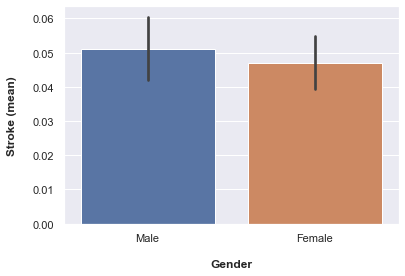

In [8]:
plt.figure(figsize=(6,4))
sns.barplot(x="gender", y="stroke", data=df)
plt.xticks(list(gender_conversion.values()), list(gender_conversion.keys()))
plt.xlabel("\nGender", fontweight="bold")
plt.ylabel("Stroke (mean)\n", fontweight="bold")
plt.show()

The wide, colored bars represent mean values and the black lines provide the boundaries of the 95% confidence interval. We note that there is no big differene between males and females.

#### Age feature

Next up is the *age* column:

In [9]:
df["age"].describe()

count    5110.000000
mean       43.226614
std        22.612647
min         0.080000
25%        25.000000
50%        45.000000
75%        61.000000
max        82.000000
Name: age, dtype: float64

The correlation between age and having a stroke is as follows:

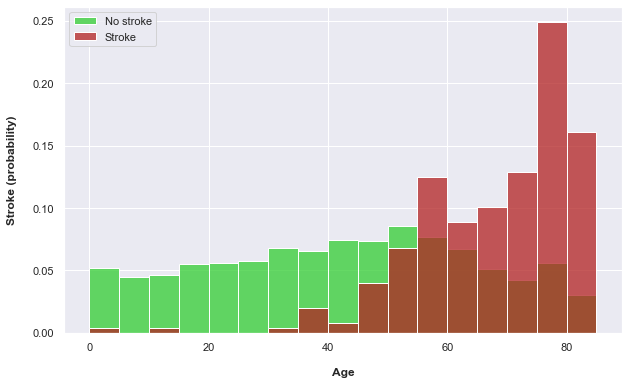

In [10]:
plt.figure(figsize=(10,6))
sns.histplot(
    df[df["stroke"] == 0]["age"], 
    binwidth=5, 
    binrange=[0, 85], 
    stat="probability", 
    color="limegreen", 
    label="No stroke",
)
sns.histplot(
    df[df["stroke"] == 1]["age"], 
    binwidth=5, 
    binrange=[0, 85], 
    stat="probability", 
    color="firebrick", 
    label="Stroke",
)
plt.xlabel("\nAge", fontweight="bold")
plt.ylabel("Stroke (probability)\n", fontweight="bold")
plt.legend()
plt.show()

The sum of the bar heights for each scenario (stroke vs. no stroke) equals unity. We can infer that the chances of having a stroke significantly increase with age.

#### Hypertension feature

The *hypertension* field takes on the values 0 (no hypertension) and 1 (hypertension): 

In [11]:
df["hypertension"].value_counts()

0    4612
1     498
Name: hypertension, dtype: int64

The relation with *stroke* can be visualized as follows:

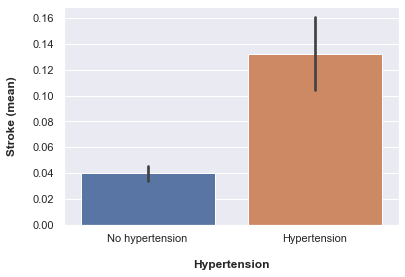

In [12]:
hypertension_conversion = {"No hypertension": 0, "Hypertension": 1}
plt.figure(figsize=(6,4))
sns.barplot(x="hypertension", y="stroke", data=df)
plt.xticks(list(hypertension_conversion.values()), list(hypertension_conversion.keys()))
plt.xlabel("\nHypertension", fontweight="bold")
plt.ylabel("Stroke (mean)\n", fontweight="bold")
plt.show()

We note that patients with hypertension are more likely to experience a stroke.

#### Heart disease feature

The variable *heart_disease* is either 0 (no heart disease) or 1 (heart disease):

In [13]:
df["heart_disease"].value_counts()

0    4834
1     276
Name: heart_disease, dtype: int64

The plot below shows the correlation between heart disease and strokes:

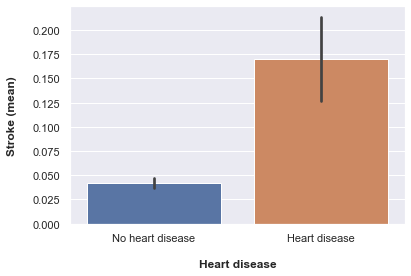

In [14]:
heart_conversion = {"No heart disease": 0, "Heart disease": 1}
plt.figure(figsize=(6,4))
sns.barplot(x="heart_disease", y="stroke", data=df)
plt.xticks(list(heart_conversion.values()), list(heart_conversion.keys()))
plt.xlabel("\nHeart disease", fontweight="bold")
plt.ylabel("Stroke (mean)\n", fontweight="bold")
plt.show()

From this plot we infer that heart disease increases the chance of experiencing a stroke.

#### Ever married feature

The column *ever_married* shows whether the patient has ever been married:

In [15]:
df["ever_married"].value_counts()

Yes    3353
No     1757
Name: ever_married, dtype: int64

To convert this feature to a numerical one, we can apply binary encoding:

In [16]:
married_conversion = {"No": 0, "Yes": 1}
df["ever_married"] = df["ever_married"].map(married_conversion)
df["ever_married"] = df["ever_married"].astype(int)

The distribution of this variable with respect to strokes is as follows:

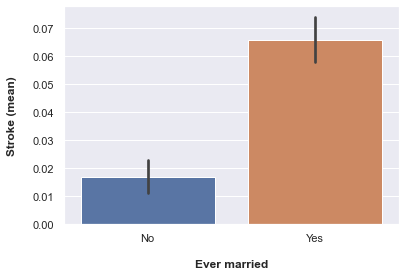

In [17]:
plt.figure(figsize=(6,4))
sns.barplot(x="ever_married", y="stroke", data=df)
plt.xticks(list(married_conversion.values()), list(married_conversion.keys()))
plt.xlabel("\nEver married", fontweight="bold")
plt.ylabel("Stroke (mean)\n", fontweight="bold")
plt.show()

It seems that marriage significantly increases the chances of having a stroke.

#### Work type feature

Next, we have the column *work_type*. There are five possible values:

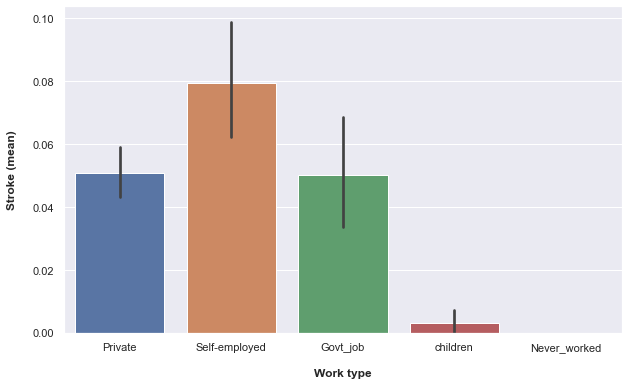

In [18]:
plt.figure(figsize=(10,6))
sns.barplot(x="work_type", y="stroke", data=df)
plt.xlabel("\nWork type", fontweight="bold")
plt.ylabel("Stroke (mean)\n", fontweight="bold")
plt.show()

Note that *Private* and *Govt_job* have a similar impact on strokes. The same is true for *children* and *Never_worked*. For this reason, we can create three categories instead without loosing much information. Moreover, the fact that a patient is a child is actually redundant as it is already captured by the *age* field.

In [19]:
df["work_type"] = df["work_type"].replace(["Self-employed"], "self-employed")
df["work_type"] = df["work_type"].replace(["Private", "Govt_job"], "employed")
df["work_type"] = df["work_type"].replace(["children", "Never_worked"], "never_employed")

# Sanity check that children (up to age 12) are never employed:
df.loc[df["age"] < 13, "work_type"] = "never_employed"

df["work_type"].value_counts()

employed          3581
self-employed      818
never_employed     711
Name: work_type, dtype: int64

Since the work type categories are nominal, we can benefit from one-hot encoding (we  will drop one column to remove redundant information) to create a numerical variable:

In [20]:
df_work_ohe = pd.get_dummies(
    df["work_type"], 
    prefix="work_ohe", 
    drop_first=True,
)
df = pd.concat([df, df_work_ohe], axis=1)
df = df.drop(["work_type"], axis=1)

#### Residence type feature

For the *residence_type* field, the distribution is as follows:

In [21]:
df["residence_type"].value_counts()

Urban    2596
Rural    2514
Name: residence_type, dtype: int64

We can convert this categorical field to a numerical one using binary encoding:

In [22]:
residence_conversion = {"Rural": 0, "Urban": 1}
df["residence_type"] = df["residence_type"].map(residence_conversion)
df["residence_type"] = df["residence_type"].astype(int)

The plot below shows the relation of this variable with *stroke*:

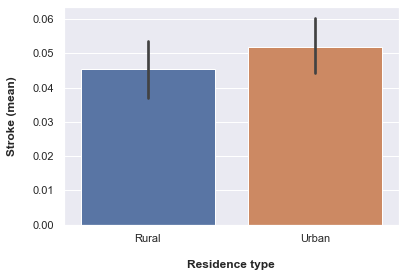

In [23]:
plt.figure(figsize=(6,4))
sns.barplot(x="residence_type", y="stroke", data=df)
plt.xticks(list(residence_conversion.values()), list(residence_conversion.keys()))
plt.xlabel("\nResidence type", fontweight="bold")
plt.ylabel("Stroke (mean)\n", fontweight="bold")
plt.show()

Residence type does seem to affect strokes much.

#### Glucose level feature

The following column, *avg_glucose_level*, describes the average glucose level in mg/dL. Its statistical details read:

In [24]:
df["avg_glucose_level"].describe()

count    5110.000000
mean      106.147677
std        45.283560
min        55.120000
25%        77.245000
50%        91.885000
75%       114.090000
max       271.740000
Name: avg_glucose_level, dtype: float64

From the [Mayo Clinic](https://www.mayoclinic.org/diseases-conditions/diabetes/diagnosis-treatment/drc-20371451) we learn the following in relation to diabetes:

> A blood sugar level less than 140 mg/dL is normal. A reading of more than 200 mg/dL after two hours indicates diabetes. A reading between 140 and 199 mg/dL indicates prediabetes.

Glucose level and strokes are related as follows:

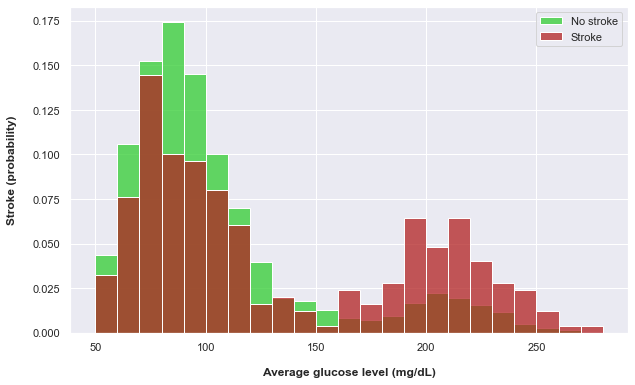

In [25]:
plt.figure(figsize=(10,6))
sns.histplot(
    df[df["stroke"] == 0]["avg_glucose_level"], 
    binwidth=10, 
    binrange=[50, 280], 
    stat="probability", 
    color="limegreen", 
    label="No stroke",
)
sns.histplot(
    df[df["stroke"] == 1]["avg_glucose_level"], 
    binwidth=10, 
    binrange=[50, 280], 
    stat="probability", 
    color="firebrick", 
    label="Stroke",
)
plt.xlabel("\nAverage glucose level (mg/dL)", fontweight="bold")
plt.ylabel("Stroke (probability)\n", fontweight="bold")
plt.legend()
plt.show()

From the above plot we infer that there is a (positive) relation between strokes and being (pre)diabetic.

#### Smoking status feature

The next feature column is *smoking_status*. There are four possible values:

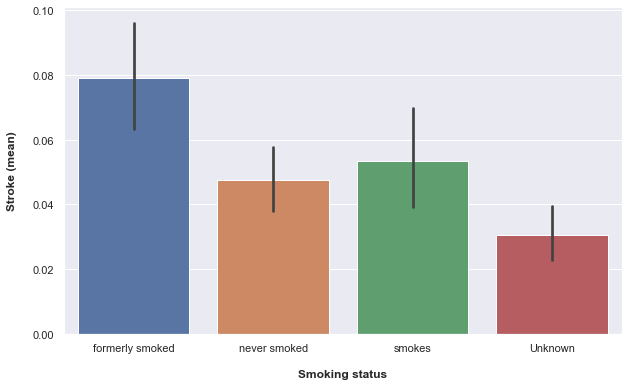

In [26]:
plt.figure(figsize=(10,6))
sns.barplot(x="smoking_status", y="stroke", data=df)
plt.xlabel("\nSmoking status", fontweight="bold")
plt.ylabel("Stroke (mean)\n", fontweight="bold")
plt.show()

Although smoking does not seem beneficial for your health, the relationship with strokes is not so clear from this plot due to the large confidence intervals.

The value *Unknown* means that information on smoking status is unavailable. To decide on what to do with this, let us look at the number of occurrences:

In [27]:
df["smoking_status"].value_counts()

never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64

Since *Unknown* occurs 1544 times in our dataset, it is best to leave it as a separate category rather than to replace it by guesses.

We consider this variable to be nominal. For that reason we can apply one-hot encoding to convert it into a numerical feature:

In [28]:
df_smoking_ohe = pd.get_dummies(
    df["smoking_status"], 
    prefix="smoking_ohe", 
    drop_first=True,
)
df_smoking_ohe = df_smoking_ohe.rename(columns={
    "smoking_ohe_never smoked": "smoking_ohe_never_smoked", 
    "smoking_ohe_formerly smoked": "smoking_ohe_formerly_smoked",
})
df = pd.concat([df, df_smoking_ohe], axis=1)
df = df.drop(["smoking_status"], axis=1)

#### BMI feature

The next column is *bmi*, the body mass index (BMI) in kg/m$^2$. Its statistical details are as follows:

In [29]:
df["bmi"].describe()

count    4909.000000
mean       28.893237
std         7.854067
min        10.300000
25%        23.500000
50%        28.100000
75%        33.100000
max        97.600000
Name: bmi, dtype: float64

From the [CDC](https://www.cdc.gov/healthyweight/assessing/bmi/adult_bmi/index.html) we learn the following in relation to obesity:

| BMI | Weight status |
| ---: | :--- |
| < 18.5 | Underweight |
| 18.5 - 24.9 | Normal weight |
| 25.0 - 29.9 | Overweight |
| > 30.0 | Obese |

From earlier we know that there are 201 missing values for this field. There are various ways to deal with this. The best option might be to infer those missing values from the other features using a regression model. For convenience, let us pick the easiest regression algorithm for this, i.e. linear regression:

In [30]:
train_data = df.dropna()
X_train = train_data.drop("bmi", axis=1)
y_train = train_data["bmi"]

test_data = df[df["bmi"].isnull()]
X_test = test_data.drop("bmi", axis=1)

model = LinearRegression()
model.fit(X_train, y_train)
y_test = model.predict(X_test)

bmi_slice = df["bmi"].copy()
bmi_slice[np.isnan(bmi_slice)] = y_test
df["bmi"] = bmi_slice

Now that our BMI values are complete, let us study the relationship with strokes:

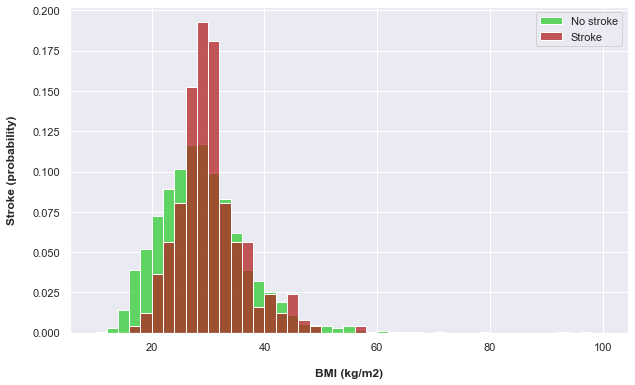

In [31]:
plt.figure(figsize=(10,6))
sns.histplot(
    df[df["stroke"] == 0]["bmi"], 
    binwidth=2, 
    binrange=[10, 100], 
    stat="probability", 
    color="limegreen", 
    label="No stroke",
)
sns.histplot(
    df[df["stroke"] == 1]["bmi"], 
    binwidth=2, 
    binrange=[10, 100], 
    stat="probability", 
    color="firebrick", 
    label="Stroke",
)
plt.xlabel("\nBMI (kg/m2)", fontweight="bold")
plt.ylabel("Stroke (probability)\n", fontweight="bold")
plt.legend()
plt.show()

The distributions for stroke and no stroke are fairly similar. However, strokes seem to be relatively common in the BMI range of 26-32 kg/m$^2$.

#### Stroke label

Finally, we have the target column *stroke*. Its values refer to whether the patient has experienced a stroke (1) or not (0).

In [32]:
df["stroke"].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

0    95.1%
1     4.9%
Name: stroke, dtype: object

We note that this dataset is extremely imbalanced. In fact, if our model would always predict 0, it would be correct 95% of the time! For this reason, accuracy will not be a suitable metric to measure model performance. Furthermore, at the modeling stage we will try to balance our dataset more to avoid any model bias.

#### Wrap-up

To conclude the preprocessing, let us verify that there are no longer any missing values and that all fields are numeric of nature:

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5110 entries, 0 to 5109
Data columns (total 14 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   gender                       5110 non-null   int64  
 1   age                          5110 non-null   float64
 2   hypertension                 5110 non-null   int64  
 3   heart_disease                5110 non-null   int64  
 4   ever_married                 5110 non-null   int64  
 5   residence_type               5110 non-null   int64  
 6   avg_glucose_level            5110 non-null   float64
 7   bmi                          5110 non-null   float64
 8   stroke                       5110 non-null   int64  
 9   work_ohe_never_employed      5110 non-null   uint8  
 10  work_ohe_self-employed       5110 non-null   uint8  
 11  smoking_ohe_formerly_smoked  5110 non-null   uint8  
 12  smoking_ohe_never_smoked     5110 non-null   uint8  
 13  smoking_ohe_smokes

In [34]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,residence_type,avg_glucose_level,bmi,stroke,work_ohe_never_employed,work_ohe_self-employed,smoking_ohe_formerly_smoked,smoking_ohe_never_smoked,smoking_ohe_smokes
0,0,67.0,0,1,1,1,228.69,36.600000,1,0,0,1,0,0
1,1,61.0,0,0,1,0,202.21,31.158272,1,0,1,0,1,0
2,0,80.0,0,1,1,0,105.92,32.500000,1,0,0,0,1,0
3,1,49.0,0,0,1,1,171.23,34.400000,1,0,0,0,0,1
4,1,79.0,1,0,1,0,174.12,24.000000,1,0,1,0,1,0


### Model building

Now that we have almost fully preprocessed our dataset, we can try to model it with various machine learning algorithms. First, we will split the data into training and test sets. After the split, we will perform a few more preprocessing steps. Then we will quickly train and test various algorithms with the Scikit-learn default settings. Finally, we will perform extensive grid searches to find better hyperparameter settings and select the best model.

#### Train-test split

First, we make a train-test split of the data:

In [35]:
X = df.drop(["stroke"], axis=1)
y = df["stroke"]
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    stratify=y, 
    random_state=0,
)

The argument *stratify=y* ensures that the train and test sets respect the orginal class proportions. Let us take a look at the distribution of the target label:

In [36]:
print("Distribution of labels in y_train:")
print(y_train.value_counts(normalize=True))

print("\nDistribution of labels in y_test:")
print(y_test.value_counts(normalize=True))

Distribution of labels in y_train:
0    0.951321
1    0.048679
Name: stroke, dtype: float64

Distribution of labels in y_test:
0    0.951076
1    0.048924
Name: stroke, dtype: float64


To ensure that all data 'lives' at the same scale, we apply standardization (meaning zero mean and unit variance) to all features. For the test set, it is considered best practice to use the mean and standard deviation of the training set.

In [37]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Before we start training, it is good practice to verify the dimensions of the data:

In [38]:
y_train = np.array(y_train)
print("Dimensions of the training set:\n")
print("Features:\t", X_train.shape, "\nLabels:\t\t", y_train.shape)

y_test = np.array(y_test)
print("\nDimensions of the test set:\n")
print("Features:\t", X_test.shape, "\nLabels:\t\t", y_test.shape)

Dimensions of the training set:

Features:	 (4088, 13) 
Labels:		 (4088,)

Dimensions of the test set:

Features:	 (1022, 13) 
Labels:		 (1022,)


#### Naive modeling

Using the Scikit-learn library, we can quickly train many different machine learning algorithms. To this end, we define a function that we can invoke for each algorithm that calculates various performance metrics from cross validation:

In [39]:
def cross_validation(
    pipeline: imbpipeline,
    metrics: Dict[str, str],
    X_train: NDArray[float], 
    y_train: NDArray[int], 
) -> Dict[str, float]:
    """Performs and assesses cross validation for a given machine learning algorithm.
    
    Args:
        pipeline: The pipeline that includes the algorithm class and, optionally, 
            also oversampling and scaling instructions.
        metrics: The different performance metrics that are evaluated on the 
            validation sets.
        X_train: The input for training.
        y_train: The labels for training.
    
    Returns:
        The mean scores for the specified performance metrics.
    """
    
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=0)
    cross_val_scores = cross_validate(
        pipeline, 
        X_train, 
        y_train, 
        cv=cv, 
        scoring=metrics,
    )

    results = {}
    for metric in metrics.keys():
        metric_name = "test_" + metric
        mean_score = round(cross_val_scores[metric_name].mean(), 3)
        results[metric] = mean_score

    return results

Let us now collect all algorithms that we want to try out. Besides K-nearest neighbors (KNN), we would like to try a model based on neural networks, namely a multilayer perceptron (MLP), as well as a tree-based model, namely a random forest (RF). In this subsection we perform a 'quick and dirty' analysis using the Scikit-learn default settings for the algorithms.

In [40]:
algorithms = {
    "K-nearest neighbors": KNeighborsClassifier(),
    "Multilayer perceptron": MLPClassifier(random_state=0),
    "Random forest": RandomForestClassifier(random_state=0),
}

For each algorithm, we calculate a couple of performance metrics:

In [41]:
metrics = {
    "Precision": "precision",
    "Recall": "recall",
    "F1": "f1",
    "Accuracy": "accuracy",
}

Next, we can perform cross validation for all these algorithms. Since our dataset is highly imbalanced, there is a risk that our models will be biased toward predicting no stroke. To combat this issue, we can apply an oversampling technique called SMOTE, which is short for Synthetic Minority Oversampling Technique. This technique makes use of the KNN algorithm to synthesize more data for the minority class. First, a random example from the minority class is selected, as well as one of its $k$ nearest neighbors. Subsequently, a new example is generated at a randomly selected location between these two points in feature space. 

The results from cross validation are as follows:

In [42]:
cv_results = []
for name, algorithm in algorithms.items():
    start_time = time.time()
    pipeline = make_imbpipeline(
        SMOTE(sampling_strategy=0.8, random_state=0),
        algorithm,
    )
    results = cross_validation(pipeline, metrics, X_train, y_train)
    elapsed_time = round(time.time() - start_time, 2)
    f1 = results["F1"]
    cv_results.append((name, f1))
    print(
        f"\n{name.upper()}\n"
        f"Duration: \t{elapsed_time} seconds"
        f"\nPerformance: \t{results}"
    )


K-NEAREST NEIGHBORS
Duration: 	2.04 seconds
Performance: 	{'Precision': 0.102, 'Recall': 0.323, 'F1': 0.154, 'Accuracy': 0.828}

MULTILAYER PERCEPTRON
Duration: 	146.72 seconds
Performance: 	{'Precision': 0.119, 'Recall': 0.287, 'F1': 0.167, 'Accuracy': 0.864}

RANDOM FOREST
Duration: 	12.93 seconds
Performance: 	{'Precision': 0.117, 'Recall': 0.134, 'F1': 0.124, 'Accuracy': 0.908}


Let us sort the obtained models by their (mean) F1-scores:

In [43]:
sorted_cv_results = sorted(cv_results, key=lambda x: x[1], reverse=True)
pd.DataFrame(sorted_cv_results, columns=["Model", "F1-score"])

,Model,F1-score
0,Multilayer perceptron,0.167
1,K-nearest neighbors,0.154
2,Random forest,0.124


#### Improved modeling

In this subsection, we aim to improve the KNN, MLP, and RF models. To this end, we can perform hyperparameter grid searches to optimize the models based on the F1-score. For convenience, let us define the following function that facilitates grid searches:

In [44]:
def grid_search(
    pipeline: imbpipeline,
    parameters: Dict[str, List[Any]],
    X_train: NDArray[float], 
    y_train: NDArray[int],
) -> Dict[str, Union[float, Dict[str, Any]]]:
    """Performs a grid search for a given algorithm to find the best hyperparameters.
    
   All parameter combinations are considered. The best parameters are those that 
   maximize the F1-score obtained through (repeated) cross validation.
    
    Args:
        pipeline: The pipeline that includes the algorithm class and, optionally, 
            also oversampling and scaling instructions.
        parameters: A grid of hyperparameters that the algorithm will loop through.
        X_train: The input for training.
        y_train: The labels for training.
    
    Returns:
        The best pipeline and the associated hyperparameter settings and F1-score.
    """
    
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=0)
    clf = GridSearchCV(pipeline, parameters, cv=cv, scoring="f1")
    clf.fit(X_train, y_train)
    results = {
        "Pipeline": clf.best_estimator_,
        "Parameters": clf.best_params_,
        "F1-score": round(clf.best_score_, 3),
    }

    return results

Rather than employing SMOTE for oversampling of the minority class, we can also undersample the majority class. The imbalanced-learn library has implemented the latter for RFs with their [BalancedRandomForestClassifier](https://imbalanced-learn.org/stable/references/generated/imblearn.ensemble.BalancedRandomForestClassifier.html) class, representing a so-called balanced RF (BRF). For the other algorithms, we will run the grid searches with and without SMOTE.

Let us now define the hyperparameters that we would like to try for the different algorithms:

In [45]:
knn_parameters = {
    "kneighborsclassifier__n_neighbors": [3, 5, 8, 13],
    "kneighborsclassifier__weights": ["uniform", "distance"],
    "kneighborsclassifier__algorithm": ["ball_tree", "kd_tree", "brute"],
    "kneighborsclassifier__p": [1, 2],
}  # Number of combinations: 4*2*3*2 = 48
mlp_parameters = {
    "mlpclassifier__hidden_layer_sizes": [(8,), (13,), (21,), (8, 8,), (13, 13,), (21, 21,)],
    "mlpclassifier__solver": ["adam", "lbfgs"],
    "mlpclassifier__alpha": [0.0001, 0.001, 0.01, 0.1],
    "mlpclassifier__random_state": [0],
}  # Number of combinations: 6*2*4 = 48
rf_parameters = {
    "randomforestclassifier__criterion": ["gini", "entropy"],
    "randomforestclassifier__max_features": ["auto", 5, 8],
    "randomforestclassifier__max_depth": [5, 8, 13, 21],
    "randomforestclassifier__ccp_alpha": [0.0, 0.0001, 0.001],
    "randomforestclassifier__random_state": [0],
}  # Number of combinations: 2*2*4*3 = 48
brf_parameters = {
    "balancedrandomforestclassifier__criterion": ["gini", "entropy"],
    "balancedrandomforestclassifier__max_features": ["auto", 5, 8],
    "balancedrandomforestclassifier__max_depth": [5, 8, 13, 21],
    "balancedrandomforestclassifier__ccp_alpha": [0.0, 0.0001, 0.001],
    "balancedrandomforestclassifier__random_state": [0],
}  # Number of combinations: 2*2*4*3 = 48

settings = {
    "K-nearest neighbors": (KNeighborsClassifier(), knn_parameters),
    "Multilayer perceptron": (MLPClassifier(), mlp_parameters),
    "Random forest": (RandomForestClassifier(), rf_parameters),
    "Balanced random forest": (BalancedRandomForestClassifier(), brf_parameters),
}

Now we are ready to perform the grid searches. For each algorithm, we collect the best F1-scores and the associated hyperparameters. The results are as follows:

In [46]:
search_results = []
for name, grid in settings.items():
    for strategy in ["(no SMOTE)", "(SMOTE)"]:
        if name.endswith("forest"):
            if strategy == "(SMOTE)":
                continue
            else:
                strategy = ""
        algorithm = grid[0]
        parameters = grid[1]
        
        start_time = time.time()
        if strategy == "(SMOTE)":
            new_name = name + " " + strategy
            pipeline = make_imbpipeline(
                SMOTE(sampling_strategy=0.8, random_state=0),
                algorithm,
            )
        else:
            new_name = name + " " + strategy
            pipeline = make_imbpipeline(algorithm)
        results = grid_search(pipeline, parameters, X_train, y_train)
        elapsed_time = round((time.time() - start_time) / 60, 2)

        best_pipeline = results["Pipeline"]
        best_parameters = results["Parameters"]
        best_f1_score = results["F1-score"]
        search_results.append((
            best_f1_score,
            new_name, 
            best_parameters, 
            best_pipeline, 
        ))
        print(
            f"\n\n{new_name.upper()}\n"
            f"Duration: \t\t{elapsed_time} minutes\n"
            f"Best F1-score: \t\t{best_f1_score}\n"
            f"Hyperparameters: \t{best_parameters}"
        )



K-NEAREST NEIGHBORS (NO SMOTE)
Duration: 		1.19 minutes
Best F1-score: 		0.083
Hyperparameters: 	{'kneighborsclassifier__algorithm': 'ball_tree', 'kneighborsclassifier__n_neighbors': 3, 'kneighborsclassifier__p': 1, 'kneighborsclassifier__weights': 'distance'}


K-NEAREST NEIGHBORS (SMOTE)
Duration: 		1.81 minutes
Best F1-score: 		0.184
Hyperparameters: 	{'kneighborsclassifier__algorithm': 'ball_tree', 'kneighborsclassifier__n_neighbors': 13, 'kneighborsclassifier__p': 1, 'kneighborsclassifier__weights': 'uniform'}


MULTILAYER PERCEPTRON (NO SMOTE)
Duration: 		20.98 minutes
Best F1-score: 		0.147
Hyperparameters: 	{'mlpclassifier__alpha': 0.001, 'mlpclassifier__hidden_layer_sizes': (21,), 'mlpclassifier__random_state': 0, 'mlpclassifier__solver': 'lbfgs'}


MULTILAYER PERCEPTRON (SMOTE)
Duration: 		37.56 minutes
Best F1-score: 		0.222
Hyperparameters: 	{'mlpclassifier__alpha': 0.1, 'mlpclassifier__hidden_layer_sizes': (8,), 'mlpclassifier__random_state': 0, 'mlpclassifier__solver': 

To select the most suitable algorithm, let us sort them by their F1-scores:

In [47]:
sorted_search_results = sorted(search_results, key=lambda x: x[0], reverse=True)
model_results = pd.DataFrame(
    sorted_search_results, 
    columns=["F1-score", "Model", "Hyperparameters", "Pipeline"],
)
model_results.drop(columns=["Pipeline"], inplace=True)
model_results

,F1-score,Model,Hyperparameters
0,0.228,Balanced random forest,"{'balancedrandomforestclassifier__ccp_alpha': 0.0, 'balancedrandomforestclassifier__criterion': 'gini', 'balancedrandomforestclassifier__max_depth': 21, 'balancedrandomforestclassifier__max_features': 5, 'balancedrandomforestclassifier__random_state': 0}"
1,0.222,Multilayer perceptron (SMOTE),"{'mlpclassifier__alpha': 0.1, 'mlpclassifier__hidden_layer_sizes': (8,), 'mlpclassifier__random_state': 0, 'mlpclassifier__solver': 'adam'}"
2,0.184,K-nearest neighbors (SMOTE),"{'kneighborsclassifier__algorithm': 'ball_tree', 'kneighborsclassifier__n_neighbors': 13, 'kneighborsclassifier__p': 1, 'kneighborsclassifier__weights': 'uniform'}"
3,0.147,Multilayer perceptron (no SMOTE),"{'mlpclassifier__alpha': 0.001, 'mlpclassifier__hidden_layer_sizes': (21,), 'mlpclassifier__random_state': 0, 'mlpclassifier__solver': 'lbfgs'}"
4,0.083,K-nearest neighbors (no SMOTE),"{'kneighborsclassifier__algorithm': 'ball_tree', 'kneighborsclassifier__n_neighbors': 3, 'kneighborsclassifier__p': 1, 'kneighborsclassifier__weights': 'distance'}"
5,0.030,Random forest,"{'randomforestclassifier__ccp_alpha': 0.0, 'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__max_depth': 21, 'randomforestclassifier__max_features': 5, 'randomforestclassifier__random_state': 0}"


Based on the F1-score, the BRF performs best. Note the significant improvement that SMOTE gives for the KNN and MLP algorithms, illustrating the importance of class balancing efforts. Note that the BRF does not require any pruning, which is controlled by the parameter *ccp_alpha*. The reason for this is that RFs are often regularized sufficiently already through ensembling.

Now that we have identified the most optimal hyperparamters, we can build our final BRF model. Let us save the model as a pickle file so that it can be easily retrieved for future use:

In [48]:
best_params = sorted_search_results[0][2]
best_params = {param.split("__")[1]: val for param, val in best_params.items()}
best_model = BalancedRandomForestClassifier(**best_params)
best_model.fit(X_train, y_train)
best_model_path = "model_weights_20211221.pkl"
joblib.dump(best_model, best_model_path)

['model_weights_20211221.pkl']

### Conclusions

In this final section we will look at some characteristics of our final BRF model and see how it performs on our test set. We will end with a discussion on our results.

#### Model characteristics

A nice thing about RFs is that we can easily infer what the relative importance is of the different features. Studying the features this way also provides validation with respect to the exploratory analysis we performed earlier.

In [49]:
rf = joblib.load(best_model_path)
weights = list(rf.feature_importances_.round(3))
feature_names = list(X.columns)
relevancies = list(zip(feature_names, weights))
sorted_relevancies = sorted(relevancies, key=lambda x: x[1], reverse=True)
pd.DataFrame(sorted_relevancies, columns=["Feature", "Relative importance"])

,Feature,Relative importance
0,age,0.423
1,avg_glucose_level,0.191
2,bmi,0.165
3,ever_married,0.034
4,hypertension,0.029
5,work_ohe_self-employed,0.026
6,heart_disease,0.023
7,residence_type,0.023
8,gender,0.022
9,smoking_ohe_never_smoked,0.021


From this overview, we conclude that *age*, *avg_glucose_level*, and *bmi* are the most important features to predict whether a patient is susceptible to a stroke. The results in this table are fairly consistent with our exploratory analysis.

An RF model is built up from an ensemble of decision trees. To get a better feel for our BRF model, let us visualize a random decision tree:

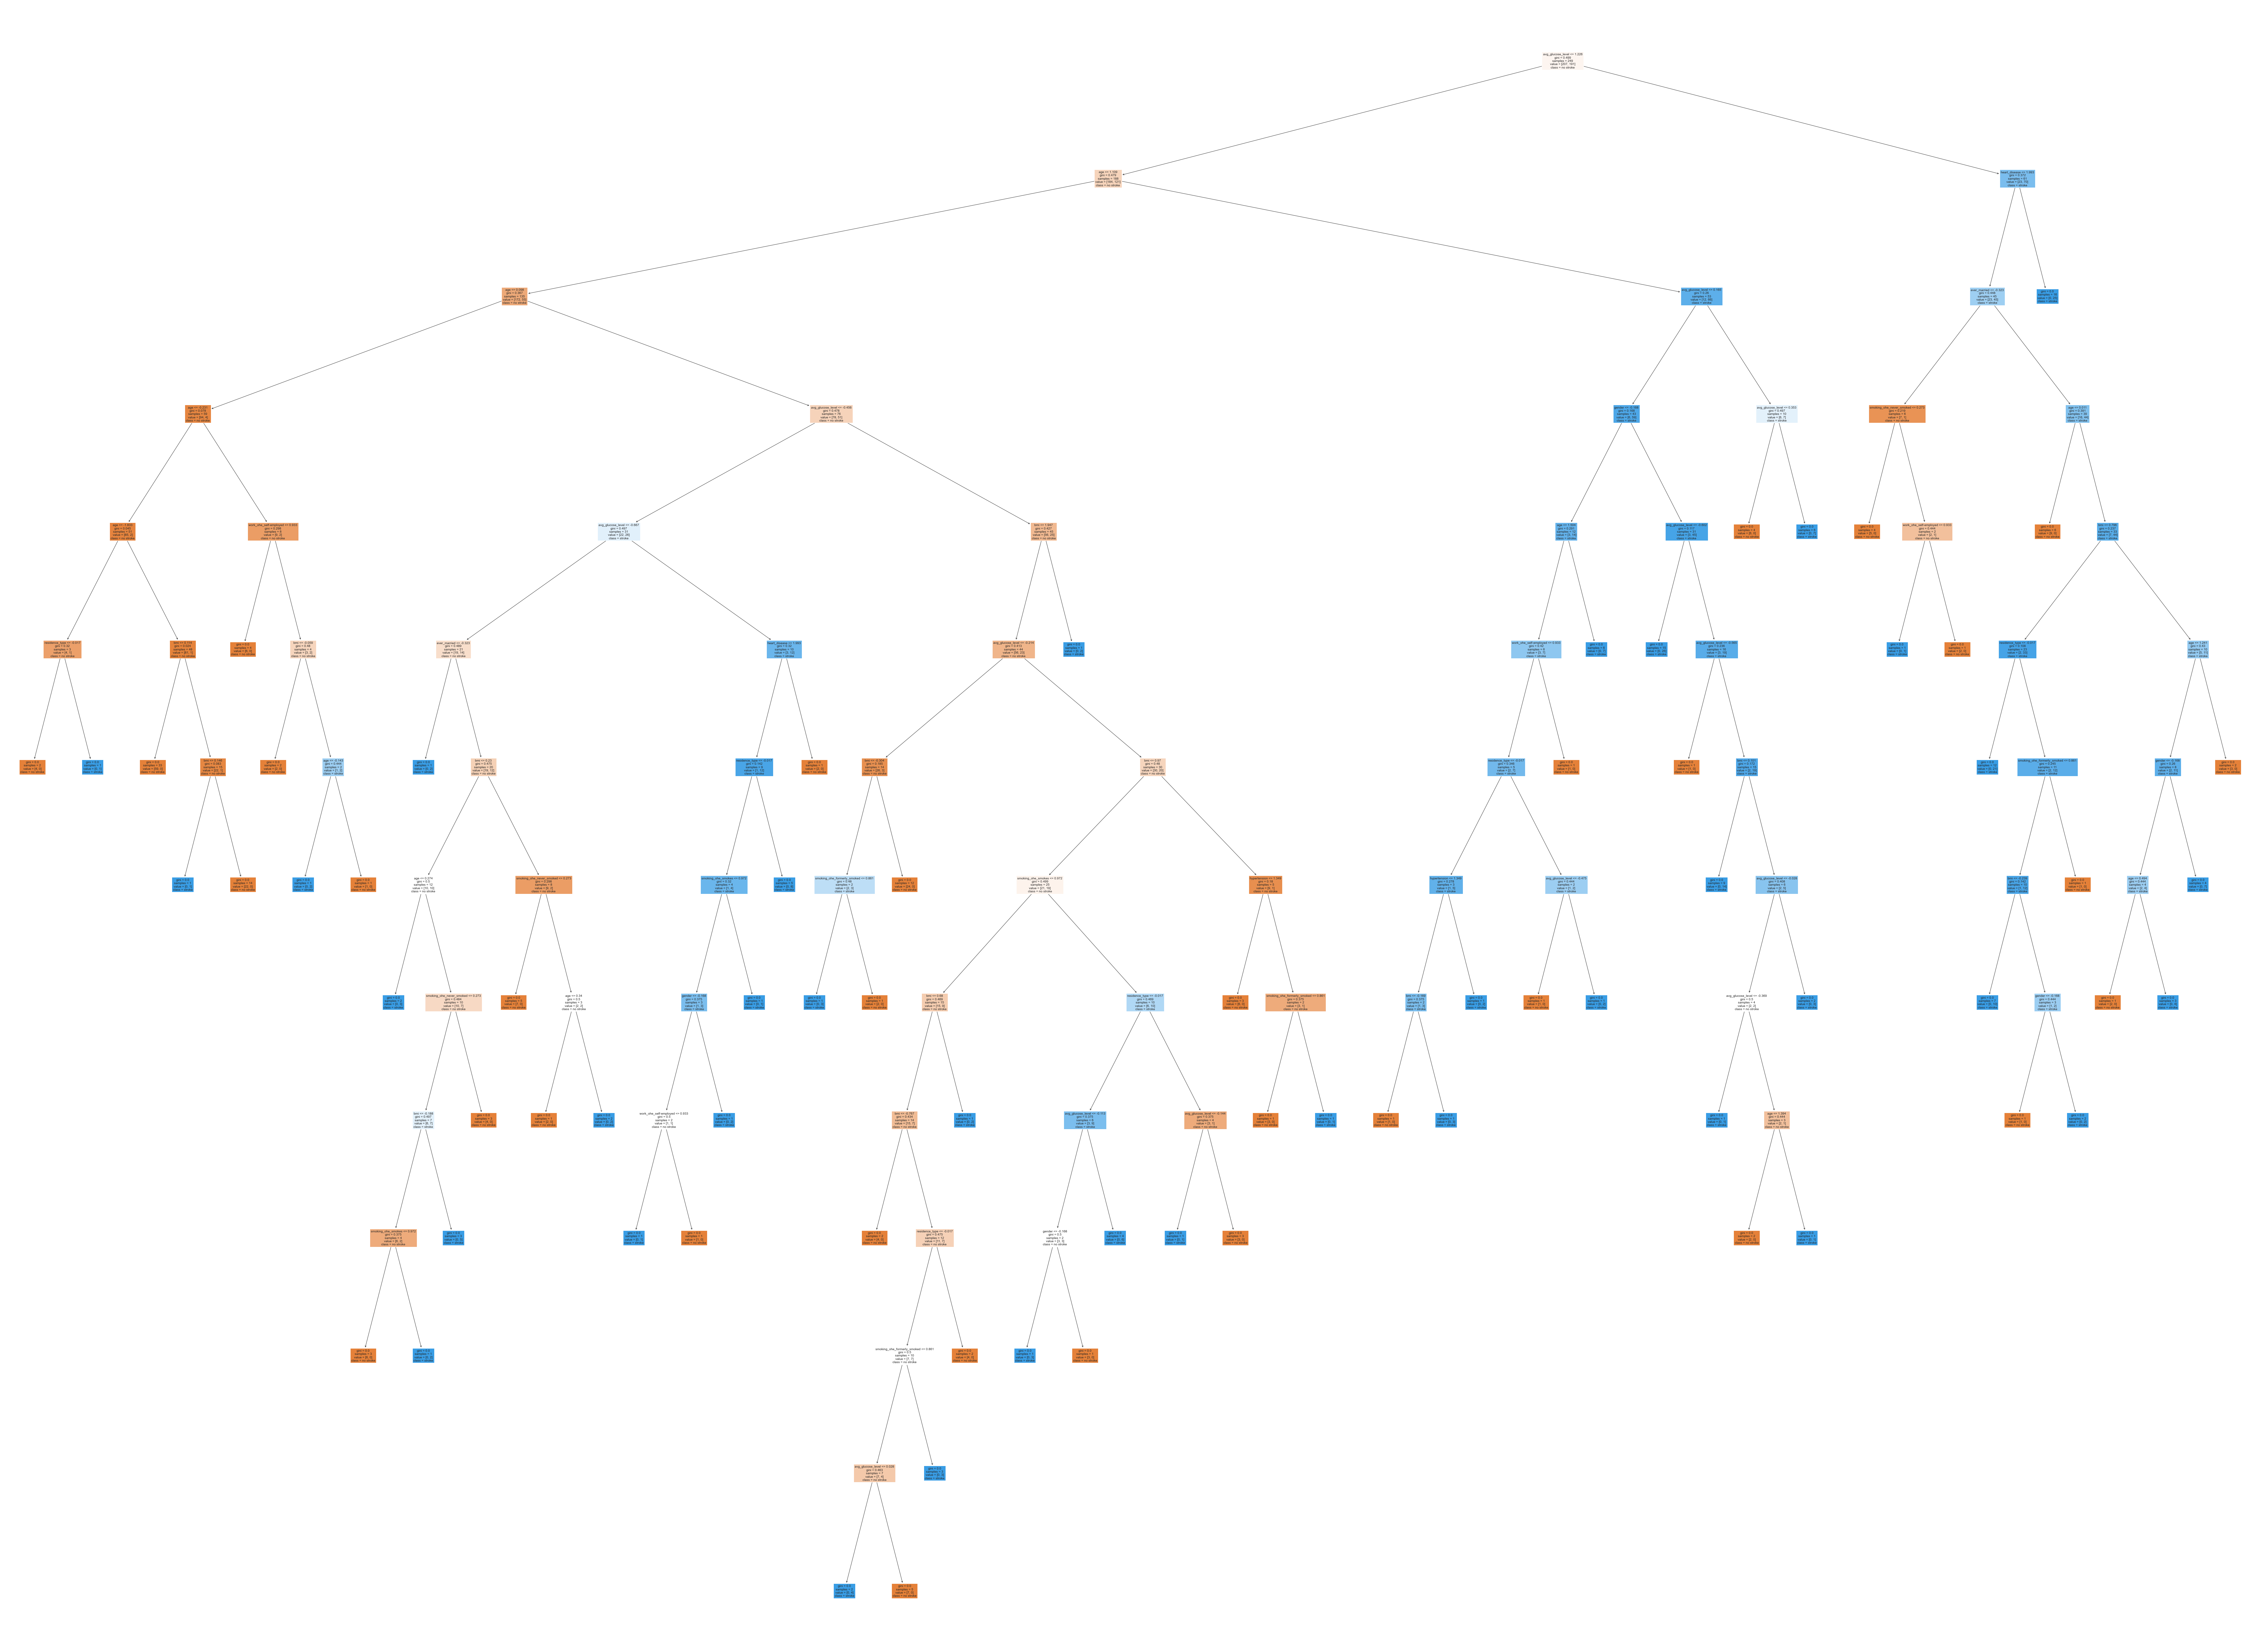

In [50]:
fig = plt.figure(figsize=(128, 96))
tree.plot_tree(
    rf.estimators_[0],
    feature_names=feature_names, 
    class_names=["no stroke", "stroke"],
    filled=True,
)
fig.savefig('rf_example_tree.png')

Each node (except leaves) splits into two nodes. The left/right node satisties/dissatisfies the condition prescribed by its parent node. The colors provide information about the class label. The bluer the node, the stronger it predicts a stroke. Likewise, the redder the node, the higher the probability that it corresponds to no stroke.

#### Test results

We have optimized our model by performing grid searches and cross validation. Now that we have selected our final model based on the F1-score, we need to test its performance on the test set that we defined earlier. Note that the test set reflects the true, imbalanced situation where strokes are rare.

In [51]:
y_pred = rf.predict(X_test)

precision = round(precision_score(y_test, y_pred), 3)
recall = round(recall_score(y_test, y_pred), 3)
f1 = round(f1_score(y_test, y_pred), 3)
accuracy = round(accuracy_score(y_test, y_pred), 3)

results = (
    f"Performance metrics for RF with:\n\n"
    f"Precision: \t{precision}\n"
    f"Recall: \t{recall}\n"
    f"F1-score: \t{f1}\n"
    f"Accuracy: \t{accuracy}"
)
print(results)

Performance metrics for RF with:

Precision: 	0.126
Recall: 	0.82
F1-score: 	0.218
Accuracy: 	0.712


The confusion matrix is given by:

Text(0, 0.5, 'True label\n')

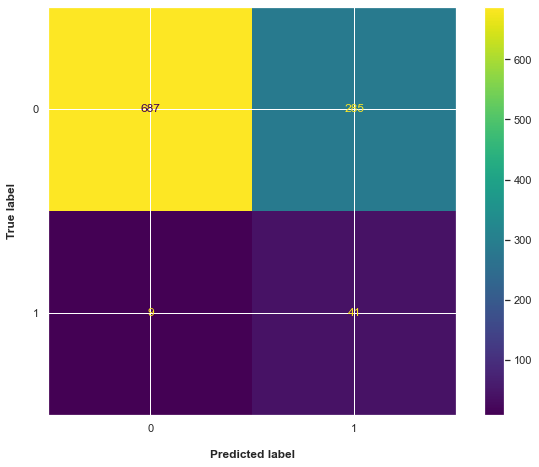

In [52]:
fig, ax = plt.subplots(figsize=(10,7.5))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax)
plt.xlabel("\nPredicted label", fontweight="bold")
plt.ylabel("True label\n", fontweight="bold")

From left to right, the first row of the confusion matrix contains the True Negatives (TNs) and the False Positives (FPs). The second row, again from left to right, contains the False Negatives (FNs) and the True Positives (TPs). As the diagonal contains the correct predictions, our goal has been to make this matrix as diagonal as possible. A high precision means that the FPs are suppressed, while a high recall corresponds to a low number of FNs. Ideally, both of these metrics are large. Both quantities are combined in the F1-score, which is the harmonic mean of precision and recall. For this reason, the F1-score is probably the most suitable metric to assess our model performance.

Next, we can plot the receiver operating characteristic (ROC). This curve is a useful metric to assess the model's ability to distinguish between the two classes.

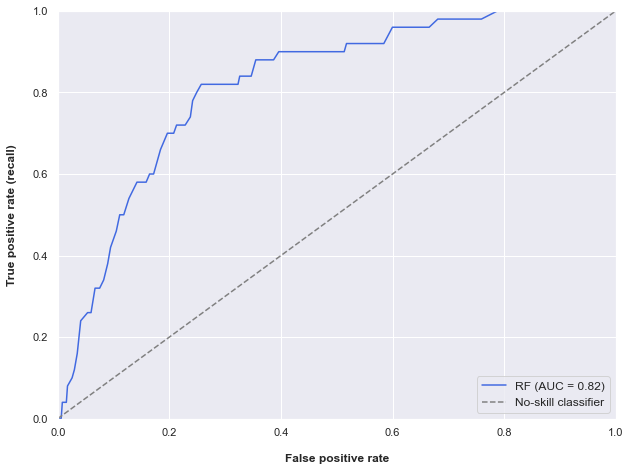

In [53]:
y_score = rf.predict_proba(X_test)[:, 1]
roc_auc = round(roc_auc_score(y_test, y_score), 3)
fpr, tpr, _ = roc_curve(y_test, y_score)

fig = plt.figure(figsize=(10,7.5))
plt.plot(
    fpr,
    tpr,
    color="royalblue",
    label=f"RF (AUC = {roc_auc})",
)
plt.plot(
    [0, 1], 
    [0, 1], 
    color="grey", 
    linestyle="--",
    label=f"No-skill classifier",
)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("\nFalse positive rate", fontweight="bold")
plt.ylabel("True positive rate (recall)\n", fontweight="bold")
plt.legend(loc="lower right", prop={"size": 12})
fig.show()

Generally, whenever the area under the curve (AUC) is greater than 0.8 the class separation is considered good.

Let us also visualize the precision-recall curve for different classification thresholds:

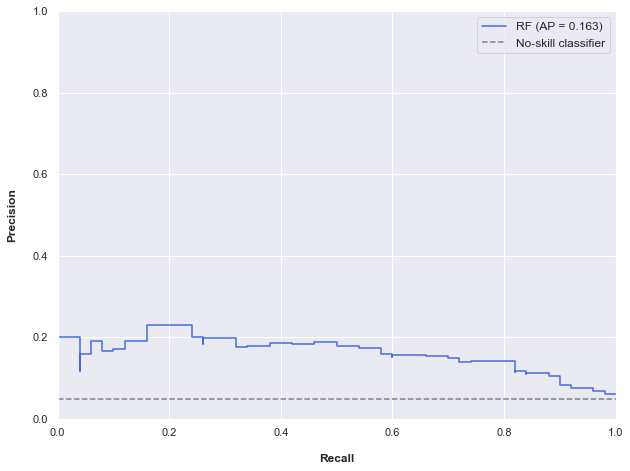

In [54]:
ap = round(average_precision_score(y_test, y_score), 3)
frac_pos_examples = sum(y_test) / len(y_test)

fig, ax = plt.subplots(figsize=(10,7.5))
PrecisionRecallDisplay.from_predictions(
    y_test, 
    y_score,
    ax=ax, 
    color="royalblue",
    label=f"RF (AP = {ap})",
)
plt.plot(
    [0, 1], 
    [frac_pos_examples, frac_pos_examples], 
    color="grey", 
    linestyle="--",
    label=f"No-skill classifier",
)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("\nRecall", fontweight="bold")
plt.ylabel("Precision\n", fontweight="bold")
plt.legend(loc="upper right", prop={"size": 12})

Based on this curve, shifting the classification threshold would not improve the results.

#### Summary and discussion

In this notebook we have considered various machine learning algorithms to predict strokes in patients. Before modeling, we performed some exploratory data analyses (mainly visual) and converted the categorical data into numerical data using either binary encoding or one-hot encoding. The missing BMI values were imputed from a linear regression model that was trained on the remaining data. To avoid any scale issues, we also standardized all features, i.e. we enforced a zero mean and unit variance.

After having fully preprocessed the data, we applied cross validation to three different machine learning algorithms using the Scikit-learn default settings. We trained K-nearest neighbors, multilayer perceptron, and random forest classifiers. To tackle the issue of significantly imbalanced class labels, we appealed to the SMOTE algorithm to oversample the stroke labels, creating a more balanced training set.

Subsequently, we performed grid searches to find more optimal sets of hyperparameters. This time, instead of SMOTE, we tried out imbalanced-learn's BalancedRandomForestClassifier to build a (balanced) random forest. Rather than oversampling the minority class, it undersamples the majority class. For the other two algorithms, we ran grid searches both with and without SMOTE. The (balanced) random forest model came out best from cross validation based on the F1-score. In general, all models that were trained with under- or oversampling performed significantly better than the ones that were trained without.

Finally, we investigated the obtained random forest model in more detail. In particular, we looked at the relative importance of the different features and visualized a random decision tree. As it turned out, age is by far the most important feature in predicting strokes. To assess the performance of this model in a more realistic setting, we had it predict on a hold-out test set that reflected the true class proportions. Although recall is decent (0.82), precision (0.13) is rather poor. Unfortunately, the precision-recall curve does not show potential for improvement upon shifting the classification threshold. The ROC AUC score is pretty good, which means that the binary classes are sufficiently separated.

To obtain a better performing model, more research is needed. Perhaps feature selection could benefit the model's performance. To arrive at a 'stronger' feature set, one could for example apply recursive feature elimination. Furthermore, one could try other machine learning algorithms. A promising choice would be XGBoost; over the last years, this algorithm has shown great perfomance in a wide variety of tasks.